In [0]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import models, transforms, datasets
from scipy.stats import norm

In [2]:
# Batch size
batch_size = 300

## Load the MNIST dataset and apply tensor-transformation to both train and test data 
## Hint: Checkout documentation for "torchvision.datasets.MNIST()"
# MNIST Dataset

train_dataset = torchvision.datasets.MNIST(root='../../data/',
                                           train=True, 
                                           transform=transforms.ToTensor(),
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='../../data/',
                                          train=False, 
                                          transform=transforms.ToTensor())



## Setup a batch loader to fetch data batch by batch
## Hint: Checkout "torch.utils.data.DataLoader()"
# Data Loader (Input Pipeline)

trainloader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)

testloader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=1000, 
                                          shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

9920512it [00:00, 28800065.31it/s]                            


Extracting ../../data/MNIST/raw/train-images-idx3-ubyte.gz


32768it [00:00, 449449.48it/s]
  1%|          | 16384/1648877 [00:00<00:11, 145235.79it/s]

Extracting ../../data/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:00, 7316701.72it/s]                            
8192it [00:00, 179502.96it/s]


Extracting ../../data/MNIST/raw/t10k-images-idx3-ubyte.gz
Extracting ../../data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


In [0]:
class Net(nn.Module):
    def __init__(self, num_latent):
        super().__init__()
        
        #So here we will first define layers for encoder network
        self.encoder = nn.Sequential(nn.Conv2d(1, 3, 3, padding=1),
                                     nn.MaxPool2d(2, 2),
                                     nn.BatchNorm2d(3),
                                     nn.Conv2d(3, 16, 3, padding=1),
                                     nn.MaxPool2d(2, 2),
                                     nn.BatchNorm2d(16),
                                     nn.Conv2d(16, 16, 3, padding=1))
        
        #These two layers are for getting logvar and mean
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.mean = nn.Linear(128, num_latent)
        self.var = nn.Linear(128, num_latent)
        
        #######The decoder part
        #This is the first layer for the decoder part
        self.expand = nn.Linear(num_latent, 128)
        self.fc3 = nn.Linear(128, 256)
        self.fc4 = nn.Linear(256, 784)
        self.decoder = nn.Sequential(nn.ConvTranspose2d(16, 16, 3, padding=1),
                                     nn.BatchNorm2d(16),
                                     nn.ConvTranspose2d(16, 3, 8),
                                     nn.BatchNorm2d(3),
                                     nn.ConvTranspose2d(3, 1, 15))
        
    def enc_func(self, x):
        #here we will be returning the logvar(log variance) and mean of our network
        x = self.encoder(x)
        x = x.view([-1, 784])
        x = F.dropout2d(self.fc1(x), 0.5)
        x = self.fc2(x)
        
        mean = self.mean(x)
        logvar = self.var(x)
        return mean, logvar
    
    def dec_func(self, z):
        #here z is the latent variable state
        z = self.expand(z)
        z = F.dropout2d(self.fc3(z), 0.5)
        z = self.fc4(z)
        z = z.view([-1, 16, 7, 7])
        
        out = self.decoder(z)
        out = F.sigmoid(out)
        return out
    
    def get_hidden(self, mean, logvar):
        if self.training:
            std = torch.exp(0.5*logvar)   #So as to get std
            noise = torch.randn_like(mean)   #So as to get the noise of standard distribution
            return noise.mul(std).add_(mean)
        else:
            return mean
    
    def forward(self, x):
        mean, logvar = self.enc_func(x)
        z = self.get_hidden(mean, logvar)
        out = self.dec_func(z)
        return out, mean, logvar

In [0]:
def VAE_loss(out, target, mean, logvar):
    category1 = nn.BCELoss()
    bce_loss = category1(out, target)
    
    #We will scale the following losses with this factor
    scaling_factor = out.shape[0] * out.shape[1] * out.shape[2] * out.shape[3]
    
    ####Now we are gonna define the KL divergence loss
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    kl_loss = -0.5 * torch.sum(1 + logvar - mean**2 - torch.exp(logvar))
    kl_loss /= scaling_factor
    
    return bce_loss + kl_loss

In [0]:
def train(trainloader, iters, model, device, optimizer, print_every):
    counter = 0
    for i in range(iters):
        model.train()
        model.to(device)
        for images, _ in trainloader:
            images = images.to(device)
            optimizer.zero_grad()
            out, mean, logvar = model(images)
            loss = VAE_loss(out, images, mean, logvar)
            loss.backward()
            optimizer.step()
            
        if(counter % print_every == 0):
            model.eval()
            n = 10  # figure with 20x20 digits
            digit_size = 28
            figure = np.zeros((digit_size * n, digit_size * n))

            # Construct grid of latent variable values
            grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
            grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

            counter = 0
            # decode for each square in the grid
            for i, yi in enumerate(grid_x):
                for j, xi in enumerate(grid_y):
                    digit = out[counter].squeeze().cpu().detach().numpy()
                    figure[i * digit_size: (i + 1) * digit_size,
                           j * digit_size: (j + 1) * digit_size] = digit
                    counter += 1

            plt.figure(figsize=(10, 10))
            plt.imshow(figure, cmap='bone')
            plt.show()  

        counter += 1
        print(counter)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


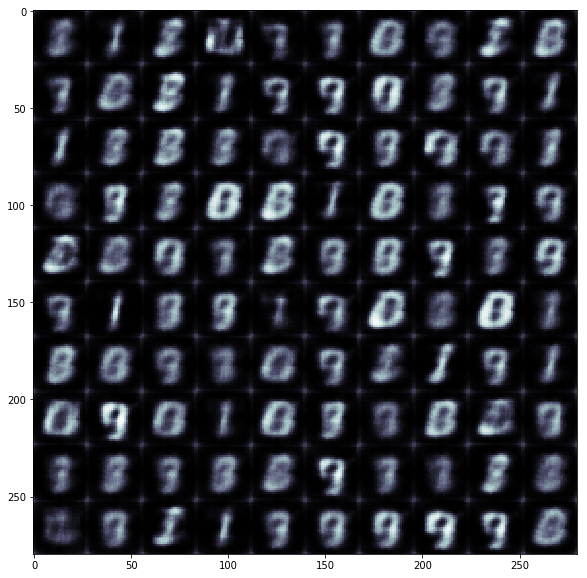

101
102
103
104
105


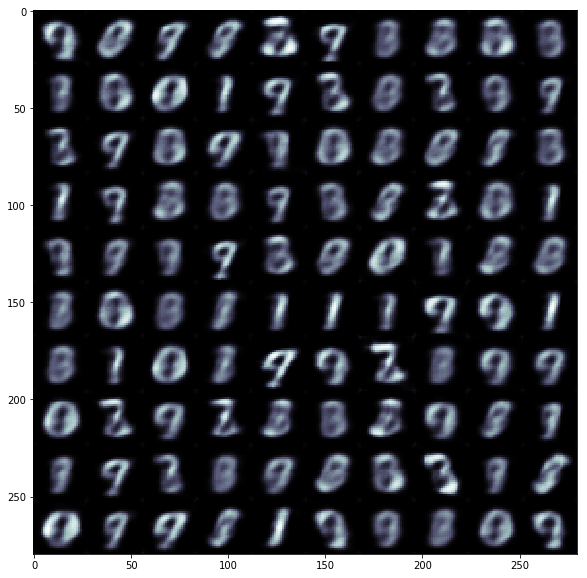

101
102
103
104
105


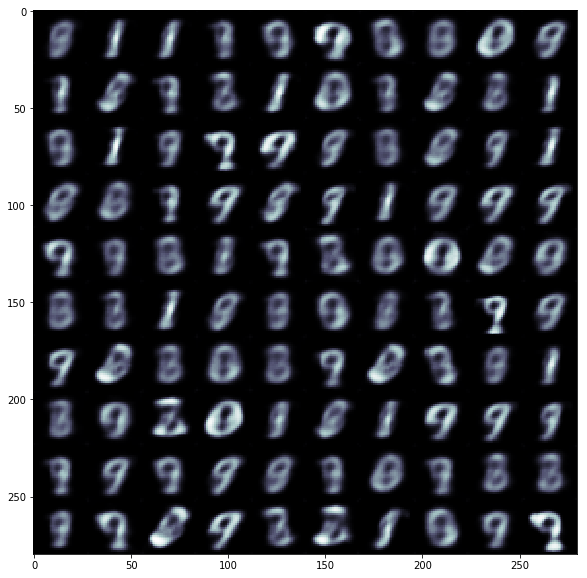

101
102
103
104
105


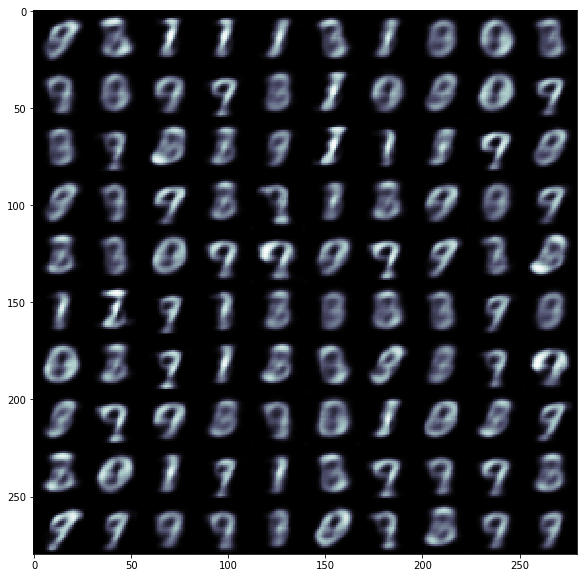

101
102
103
104
105


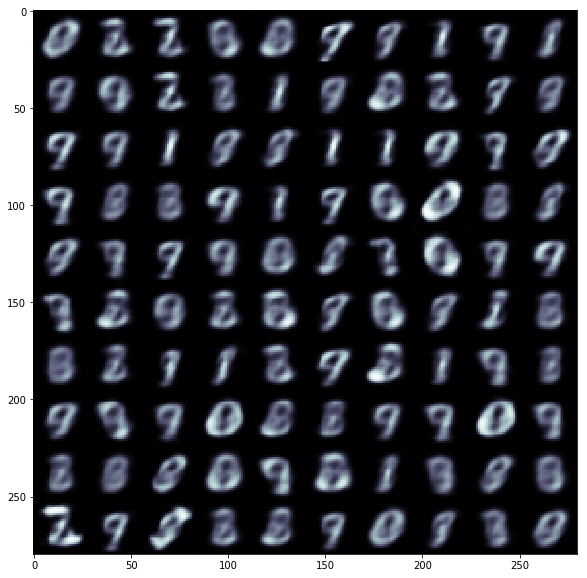

101
102
103
104
105


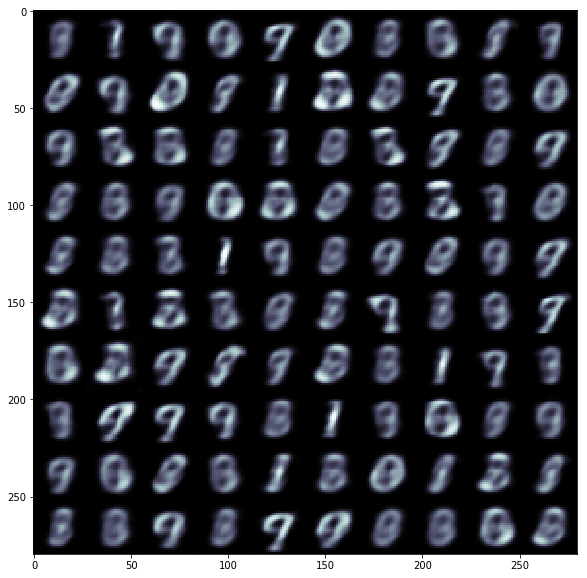

101
102
103
104
105


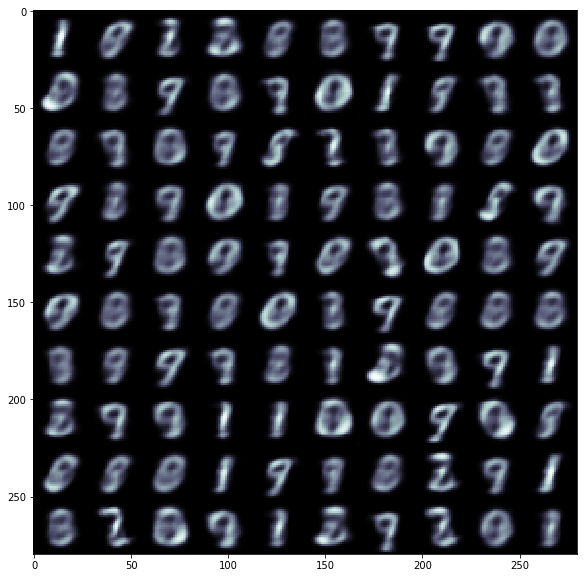

101
102
103
104
105


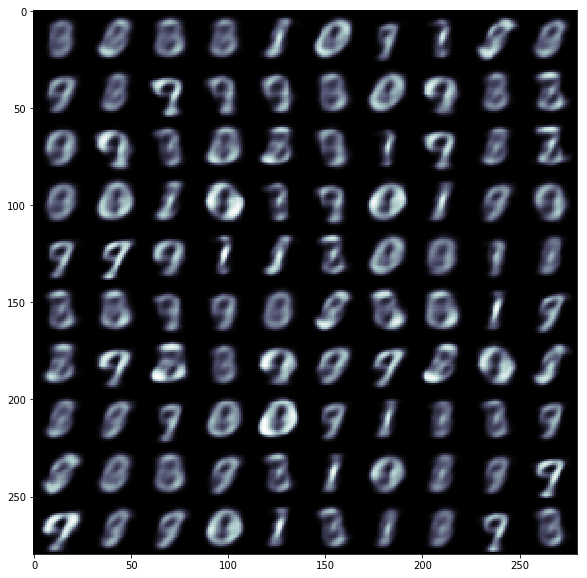

101
102
103
104
105


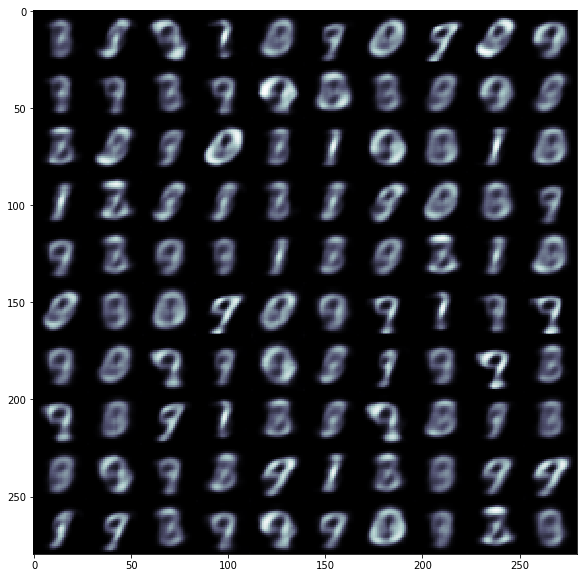

101
102
103
104
105


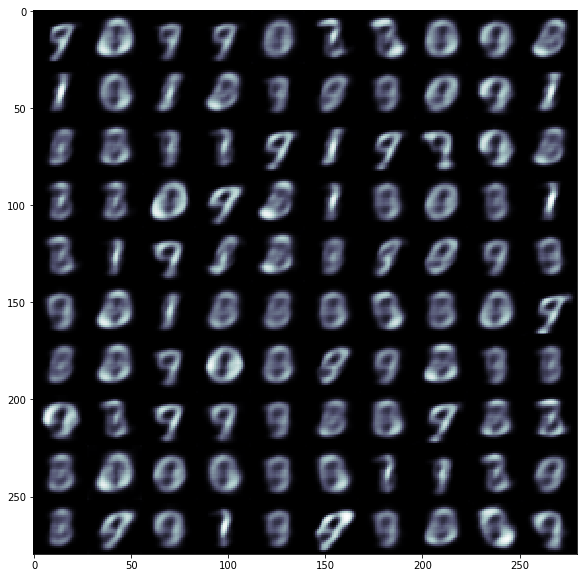

101
102
103
104
105


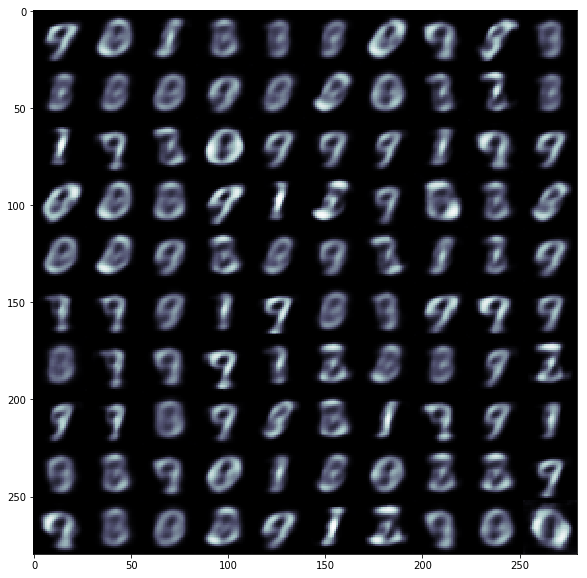

101
102
103
104
105


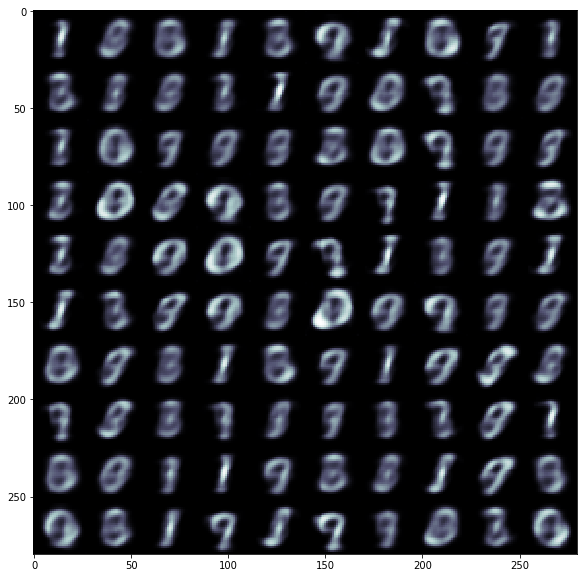

101
102
103
104
105


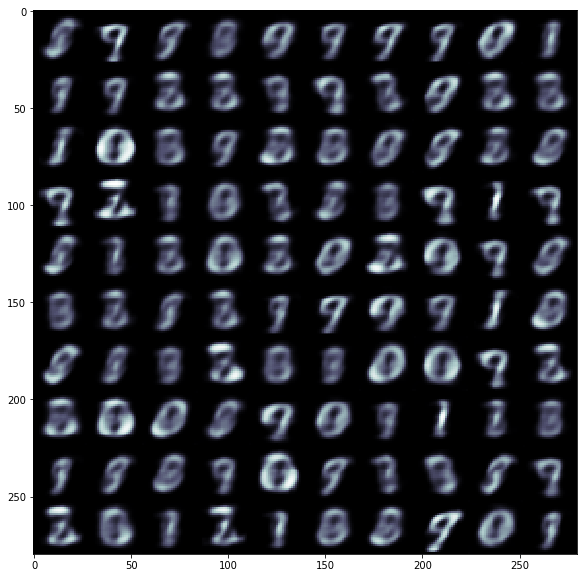

101
102
103
104
105


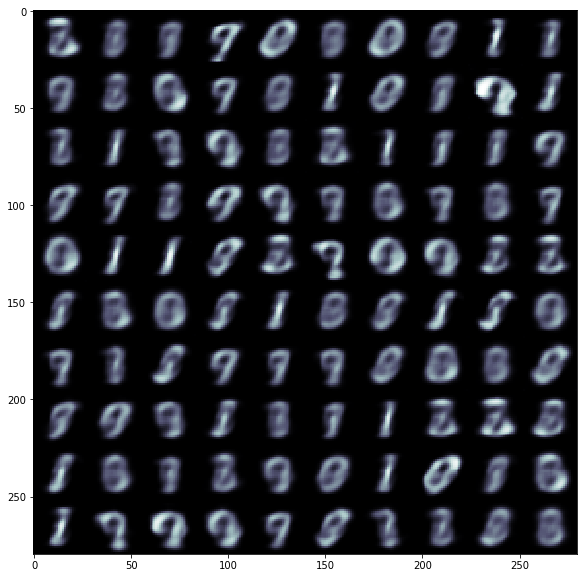

101
102
103
104
105


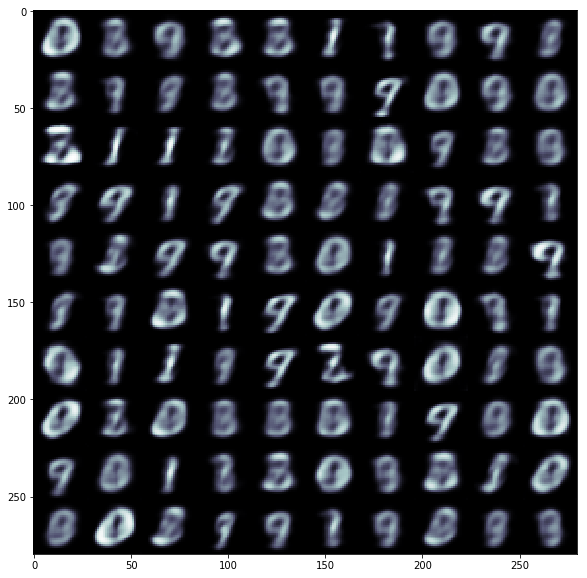

101
102
103
104
105


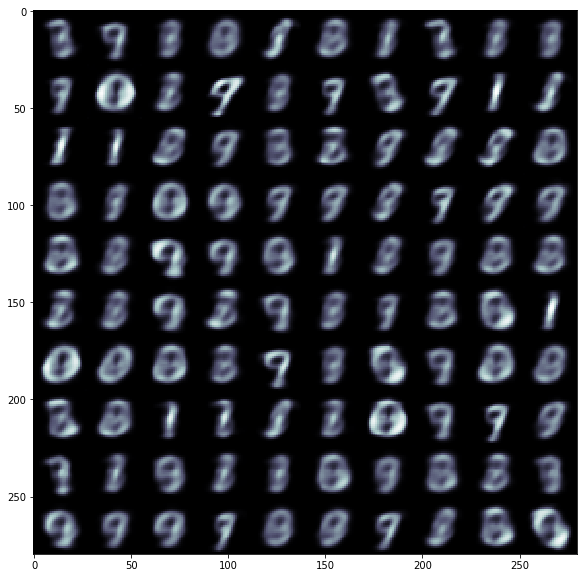

101
102
103
104
105


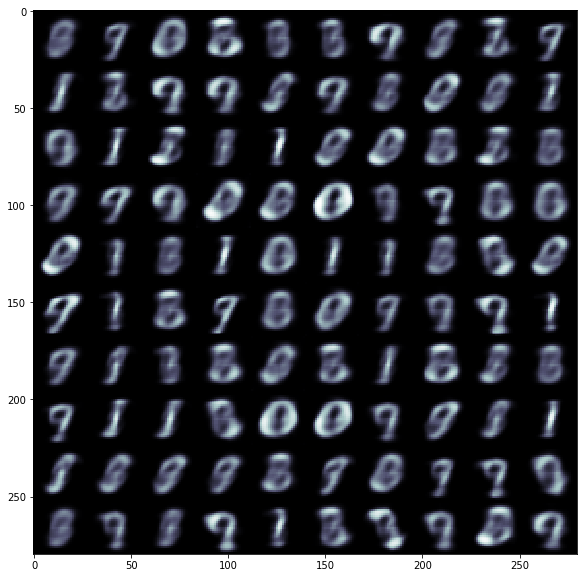

101
102
103
104
105


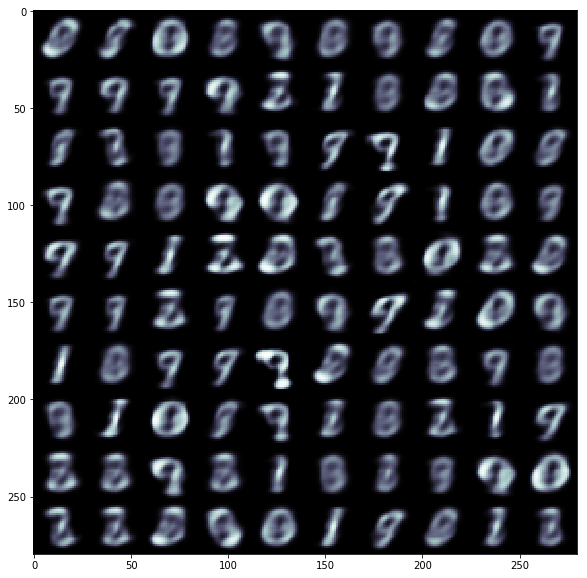

101
102
103
104
105


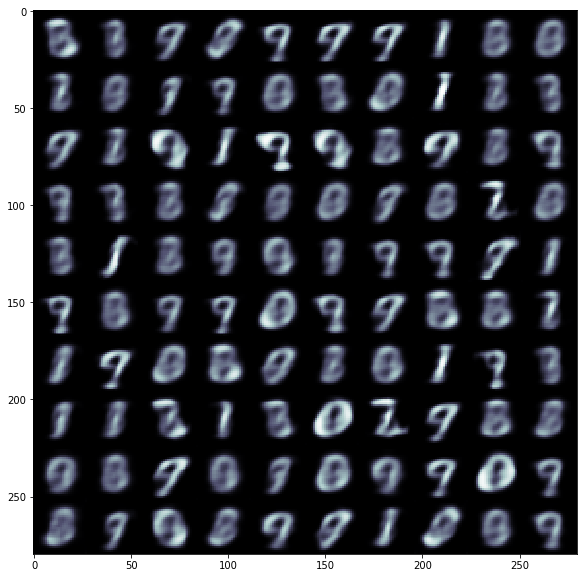

101
102
103
104
105


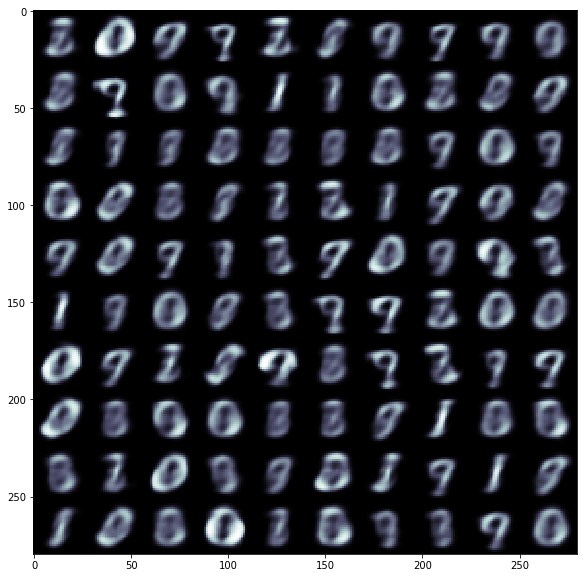

101
102
103
104
105


In [6]:
iters = 100
num_latent = 3
print_every = 5    #print after every 5 iterations
model = Net(num_latent)

device = ('cuda' if torch.cuda.is_available() else 'cpu')
import torch.optim as optim
optimizer = optim.Adam(model.parameters(), lr=1e-3)

train(trainloader, iters, model, device, optimizer, print_every)

In [0]:
i = 0
for images, label in testloader:
    images = images.to(device)
    mean, logvar = model.enc_func(images)
    z = model.get_hidden(mean, logvar)
    y = label
    if i == 0:
      yy = y
      zz = z
    else:
      yy = torch.cat((yy, y), 0)
      zz = torch.cat((zz, z), 0)
    i += 1

In [0]:

from mpl_toolkits.mplot3d import axes3d


In [0]:
latent_vectors = zz.cpu().squeeze().detach().numpy()
labels = yy.cpu().squeeze().detach().numpy()

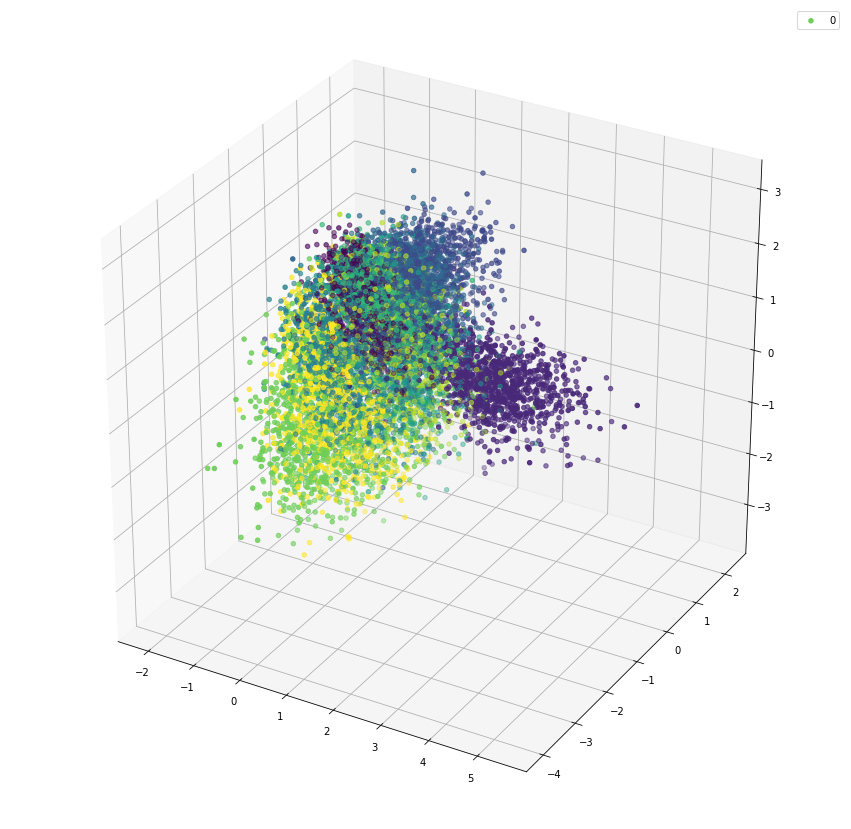

In [10]:
plt.figure(figsize = (15, 15))
ax = plt.gca(projection='3d')
ax.scatter(latent_vectors[:,0], latent_vectors[:,1], latent_vectors[:, 2], c=labels)
plt.legend(['0', '1', '2', '3', '4 ', '5', '6', '7', '8', '9'])

In [0]:
from ipywidgets import interact
def play_around(x, y, z):
    out = model.dec_func(torch.tensor([[float(x), float(y), float(z)]]).to(device))
    out = out.to('cpu')
    return(out.squeeze().detach().numpy())

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


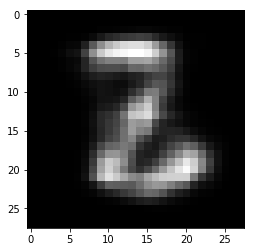

In [13]:
plt.imshow(play_around(0.1, 0.5, 2), cmap='gray')

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


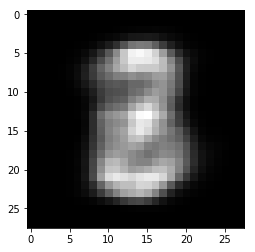

In [14]:
plt.imshow(play_around(0.1, 0.2, 1), cmap='gray')

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


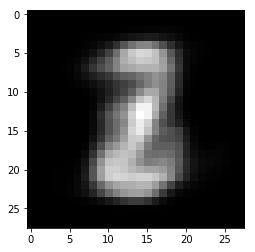

In [15]:
plt.imshow(play_around(1, 0.2, 1), cmap='gray')

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


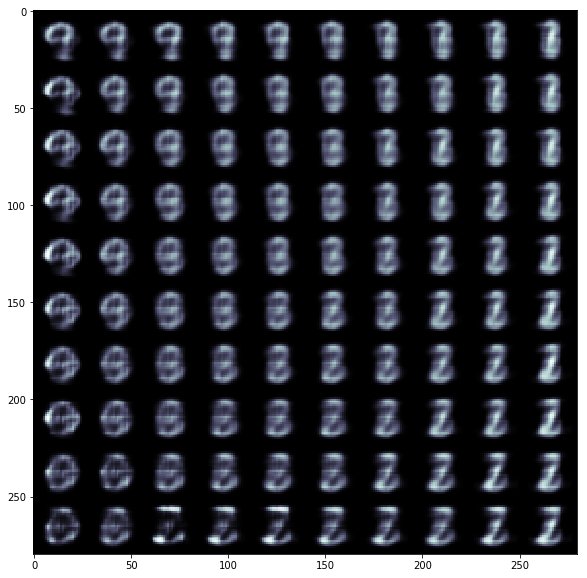

In [17]:
n = 10  # figure with 20x20 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

# Construct grid of latent variable values
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

counter = 0
# decode for each square in the grid
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        out = model.dec_func(torch.tensor([[float(xi), float(yi), float(1)]]).to(device))
        out = out.to('cpu')
        digit = out.squeeze().cpu().detach().numpy()
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit
        counter += 1

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='bone')
plt.show()  